# Anomalies Extraction Functions

In [ ]:
def generate_enhanced_pose_summary(df):
    summaries = []
    grouped = df.groupby('Subject')

    for subject_id, group in grouped:
        label = group['Label'].iloc[0]

        # Range of motion
        hip_range = group['HipAngles'].max() - group['HipAngles'].min()
        knee_range = group['KneeAngles'].max() - group['KneeAngles'].min()
        ankle_range = group['AnkleAngles'].max() - group['AnkleAngles'].min()

        # Acceleration variability (movement regularity)
        hip_acc_std = group['HipAngles_Acceleration'].std()
        knee_acc_std = group['KneeAngles_Acceleration'].std()
        ankle_acc_std = group['AnkleAngles_Acceleration'].std()

        # Jerk (3rd derivative approximation using diff of acceleration)
        hip_jerk = group['HipAngles_Acceleration'].diff().std()
        knee_jerk = group['KneeAngles_Acceleration'].diff().std()
        ankle_jerk = group['AnkleAngles_Acceleration'].diff().std()

        summary = {
            'subject_id': subject_id,
            'label': label,
            'hip_range': hip_range,
            'knee_range': knee_range,
            'ankle_range': ankle_range,
            'hip_acc_std': hip_acc_std,
            'knee_acc_std': knee_acc_std,
            'ankle_acc_std': ankle_acc_std,
            'hip_jerk': hip_jerk,
            'knee_jerk': knee_jerk,
            'ankle_jerk': ankle_jerk,
            'hip_mean': group['HipAngles'].mean(),
            'knee_mean': group['KneeAngles'].mean(),
            'ankle_mean': group['AnkleAngles'].mean(),
        }

        summaries.append(summary)

    return pd.DataFrame(summaries)

# LLM Setup

In [ ]:
from openai import OpenAI
from google.colab import userdata

client = OpenAI(api_key=userdata.get('OPENAI_API_KEY'))

def call_llm_api(prompt):
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {
                "role": "system",
                "content": (
                    "You are a clinical assistant specializing in gait analysis. "
                    "You will receive summaries of joint angle and motion data from a subject. "
                    "Your task is to determine whether the subject exhibits patterns typical of stroke patients or healthy individuals."
                )
            },
            {"role": "user", "content": prompt}
        ],
        max_tokens=700,
        temperature=0.0
    )
    return response.choices[0].message.content

In [ ]:
def parse_llm_output_flexible(text):
    text = str(text).lower()
    if "needs clinical review" in text:
        return "review"
    elif "conclusion: stroke" in text or "likely stroke" in text:
        return "Stroke"
    elif "conclusion: control" in text or "healthy" in text:
        return "Control"
    return "review"

In [ ]:
def build_llm_prompt_with_gait_profile(summary_row):
    ontology_reference = """
Ontology Reference:
- Stroke-related gait often involves reduced range of motion, higher joint jerk (indicative of erratic motion), and increased acceleration variability.
- Control (healthy) subjects usually display smoother movement, consistent acceleration, and wider joint ranges.
- A subject may be classified as Stroke if multiple joints exhibit high jerk and reduced motion range.

Diagnosis Guidance:
- If two or more joints show high jerk or low range of motion, classify as Stroke.
- If all joints appear within normal variability and smooth motion, classify as Control.
- If findings are unclear or borderline, classify as Needs clinical review.
"""

    task_instruction = """
Task:
Analyze the following gait summary using the ontology above.
Respond in this format:

Conclusion: [Stroke / Control / Needs clinical review]
Explanation: [Brief justification based on gait patterns]
"""

    subject_summary = (
        f"Subject ID: {summary_row['subject_id']}\n"
        f"Hip range: {summary_row['hip_range']:.2f}°, jerk: {summary_row['hip_jerk']:.2f}, acc. std: {summary_row['hip_acc_std']:.2f}\n"
        f"Knee range: {summary_row['knee_range']:.2f}°, jerk: {summary_row['knee_jerk']:.2f}, acc. std: {summary_row['knee_acc_std']:.2f}\n"
        f"Ankle range: {summary_row['ankle_range']:.2f}°, jerk: {summary_row['ankle_jerk']:.2f}, acc. std: {summary_row['ankle_acc_std']:.2f}\n"
        f"Average joint angles - Hip: {summary_row['hip_mean']:.2f}, Knee: {summary_row['knee_mean']:.2f}, Ankle: {summary_row['ankle_mean']:.2f}"
    )

    return f"{ontology_reference}\n\nGait Summary:\n{subject_summary}\n\n{task_instruction}"

# Classification

In [ ]:
import pandas as pd

pose_df = pd.read_csv('data/processed_gait_features_full.csv')

In [ ]:
# Create new unique subject IDs that include condition
pose_df['Subject'] = pose_df.apply(
    lambda row: f"{row['Subject']}_{'Control' if row['Label'] == 0 else 'Stroke'}", axis=1
)

In [ ]:
enhanced_df = generate_enhanced_pose_summary(pose_df)

In [ ]:
enhanced_df

,subject_id,label,hip_range,knee_range,ankle_range,hip_acc_std,knee_acc_std,ankle_acc_std,hip_jerk,knee_jerk,ankle_jerk,hip_mean,knee_mean,ankle_mean
0,Sub01_Control,0,43.162055,60.769379,26.803913,0.105771,0.196382,0.088009,0.001026,0.005270,0.002002,11.075423,24.411245,2.633496
1,Sub01_Stroke,1,46.797532,54.321876,11.637976,0.165668,0.701083,0.483499,0.112573,0.682572,0.480664,6.117771,21.568070,14.346044
2,Sub02_Control,0,35.541291,42.963785,20.065645,0.387998,0.138828,0.083309,0.380733,0.038670,0.039809,25.048347,22.657149,2.415438
3,Sub02_Stroke,1,37.400799,50.136369,22.328103,0.492131,0.509301,0.465746,0.484049,0.488272,0.457488,29.780098,30.591555,4.950646
4,Sub03_Control,0,43.636848,50.713423,26.485989,0.100283,0.156503,0.089328,0.001101,0.024522,0.013864,22.932520,20.196128,3.745019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Sub48_Stroke,1,38.761884,52.810269,17.709820,0.268931,0.171490,0.250118,0.251866,0.025636,0.242934,26.618040,19.708285,-1.612982
96,Sub49_Control,0,45.055229,57.254465,27.534317,0.212201,0.183173,0.220738,0.181034,0.019460,0.191134,10.765968,15.252491,-2.737767
97,Sub49_Stroke,1,45.276093,56.386644,28.292208,0.231473,0.210058,0.242291,0.202245,0.106706,0.221633,14.165964,25.346487,3.811086
98,Sub50_Control,0,39.370498,54.043279,22.984342,0.140749,0.281977,0.176942,0.105954,0.220732,0.161852,17.649531,24.189230,0.523635


In [ ]:
from tqdm import tqdm

# Map label to string for clarity
label_map = {0: "Control", 1: "Stroke"}

# Initialize results
all_llm_results = []

for _, row in tqdm(enhanced_df.iterrows(), total=len(enhanced_df)):
    try:
        # Build prompt using new gait profile function
        prompt = build_llm_prompt_with_gait_profile(row)

        # Call the LLM
        llm_response = call_llm_api(prompt)

        # Parse decision
        parsed_decision = parse_llm_output_flexible(llm_response)

        # Store result
        all_llm_results.append({
            "Subject": row["subject_id"],
            "Subject Condition": label_map[row["label"]],
            "LLM Output": llm_response,
            "LLM Decision": parsed_decision
        })

    except Exception as e:
        print(f"Error with {row['subject_id']}: {e}")
        all_llm_results.append({
            "Subject": row["subject_id"],
            "Subject Condition": label_map[row["label"]],
            "LLM Output": f"Exception: {e}",
            "LLM Decision": "error"
        })

# Convert to DataFrame
llm_results_df = pd.DataFrame(all_llm_results)


100%|██████████| 100/100 [03:43<00:00,  2.24s/it]


In [ ]:
# Save results + accuracy
results_df = pd.DataFrame(all_llm_results)
results_df.to_csv("llm_subject_predictions_stroke.csv", index=False)

In [ ]:
results_df

,Subject,Subject Condition,LLM Output,LLM Decision
0,Sub01_Control,Control,Conclusion: Control \nExplanation: The subjec...,Control
1,Sub01_Stroke,Stroke,Conclusion: Stroke\n\nExplanation: The subject...,Stroke
2,Sub02_Control,Control,Conclusion: Control\n\nExplanation: The subjec...,Control
3,Sub02_Stroke,Stroke,Conclusion: Stroke\n\nExplanation: The subject...,Stroke
4,Sub03_Control,Control,Conclusion: Control\n\nExplanation: The subjec...,Control
...,...,...,...,...
95,Sub48_Stroke,Stroke,Conclusion: Stroke\n\nExplanation: The subject...,Stroke
96,Sub49_Control,Control,Conclusion: Control\n\nExplanation: The subjec...,Control
97,Sub49_Stroke,Stroke,Conclusion: Stroke\n\nExplanation: The subject...,Stroke
98,Sub50_Control,Control,Conclusion: Control\n\nExplanation: The subjec...,Control


In [ ]:
import re

def categorize_llm_response(llm_output):
    text = llm_output.lower()

    # Step 1: Determine decision
    if "conclusion:" in text:
        match = re.search(r"conclusion:\s*(stroke|control|needs clinical review)", text)
        if match:
            raw = match.group(1)
            if raw == "stroke":
                decision = "stroke"
            elif raw == "control":
                decision = "control"
            else:
                decision = "uncertain"
        else:
            decision = "uncertain"
    elif "stroke" in text:
        if "consistent with stroke" in text or "likely stroke" in text:
            decision = "stroke"
        elif "not consistent" in text or "normal gait" in text:
            decision = "control"
        else:
            decision = "uncertain"
    else:
        decision = "uncertain"

    # Step 2: Determine confidence
    if any(phrase in text for phrase in [
        "clear indication", "strong evidence", "clearly consistent", "multiple anomalies"
    ]):
        confidence = "confident"
    elif any(phrase in text for phrase in [
        "borderline", "partial", "some signs", "weak evidence", "not conclusive"
    ]):
        confidence = "borderline"
    else:
        confidence = "confident" if decision != "uncertain" else "inconclusive"

    return {"decision": decision, "confidence": confidence}

In [ ]:
for entry in all_llm_results:
    parsed = categorize_llm_response(entry["LLM Output"])
    entry["LLM Decision"] = parsed["decision"]
    entry["Confidence"] = parsed["confidence"]

In [ ]:
all_llm_results

[{'Subject': 'Sub01_Control',
  'Subject Condition': 'Control',
  'LLM Output': 'Conclusion: Control  \nExplanation: The subject exhibits a wide range of motion in the hip (43.16°), knee (60.77°), and ankle (26.80°) joints, which is typical of healthy individuals. The jerk values for all joints are very low (0.00 for hip and ankle, 0.01 for knee), indicating smooth movement. Additionally, the acceleration standard deviations are low, suggesting consistent acceleration. These findings align with the patterns expected in control subjects.',
  'LLM Decision': 'control',
  'Confidence': 'confident'},
 {'Subject': 'Sub01_Stroke',
  'Subject Condition': 'Stroke',
  'LLM Output': 'Conclusion: Stroke\n\nExplanation: The subject exhibits reduced range of motion in the ankle (11.64°) and high jerk values in both the knee (0.68) and ankle (0.48). These findings align with stroke-related gait patterns, which include reduced motion range and higher joint jerk. The combination of these factors acros

# Results

In [ ]:
from collections import Counter

Counter((entry["Subject Condition"], entry["LLM Decision"], entry["Confidence"]) for entry in all_llm_results)

Counter({('Control', 'control', 'confident'): 50,
         ('Stroke', 'stroke', 'confident'): 50})

## Confusion Matrix

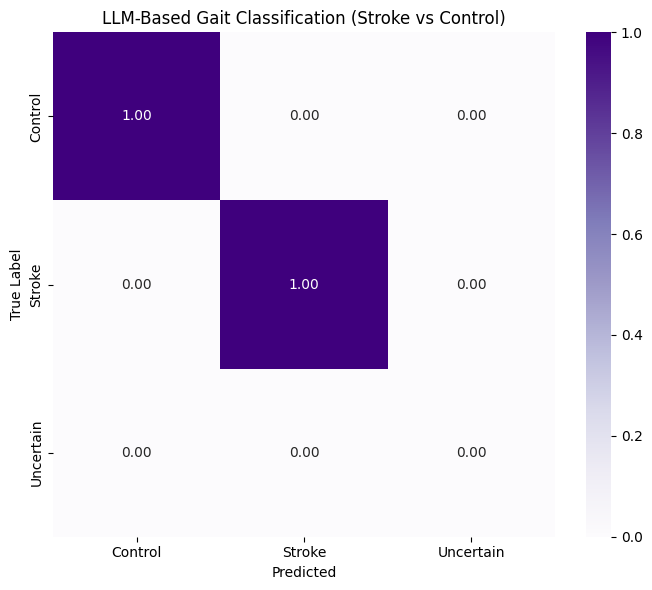

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Load your LLM classification results
df = pd.read_csv("/content/drive/MyDrive/NeuroSyncAI/stroke_dataset/llm_subject_predictions_stroke.csv")

# Normalize and clean label casing
df["Subject Condition"] = df["Subject Condition"].str.strip().str.capitalize()
df["LLM Decision"] = df["LLM Decision"].replace("review", "Uncertain").str.strip().str.capitalize()

# Define consistent label order
labels = ["Control", "Stroke", "Uncertain"]
y_true = df["Subject Condition"]
y_pred = df["LLM Decision"]

# 1. Normalized Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=labels, normalize='true')

plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Purples", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True Label")
plt.title("LLM-Based Gait Classification (Stroke vs Control)")
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score

overall_acc = accuracy_score(y_true, y_pred)
print(f"Overall Accuracy: {overall_acc:.2f}")

Overall Accuracy: 1.00


## Classification Report

In [ ]:
# 2. Classification Report (Healthy vs MCI only)
binary_report = classification_report(
    y_true, y_pred, labels=["Control", "Stroke"], output_dict=True, zero_division=0
)
binary_df = pd.DataFrame(binary_report).transpose()
display(binary_df)

,precision,recall,f1-score,support
Control,1.0,1.0,1.0,50.0
Stroke,1.0,1.0,1.0,50.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,100.0
weighted avg,1.0,1.0,1.0,100.0


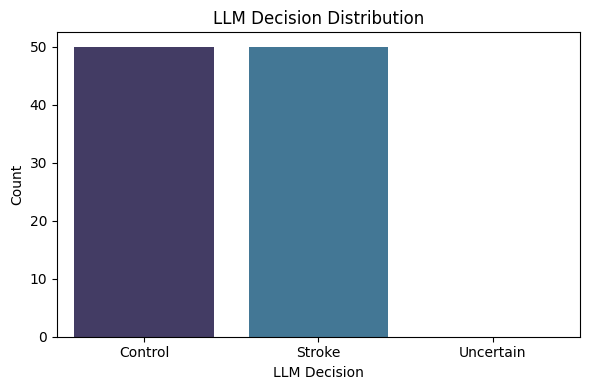

In [ ]:
# 3. Decision Distribution Chart
decision_counts = df["LLM Decision"].value_counts().reindex(labels, fill_value=0)

plt.figure(figsize=(6, 4))
sns.barplot(
    x=decision_counts.index,
    y=decision_counts.values,
    hue=decision_counts.index,
    palette="mako",
    legend=False
)
plt.ylabel("Count")
plt.title("LLM Decision Distribution")
plt.tight_layout()
plt.show()
